In [ ]:
import earthnet_minicuber as emc
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import datetime
import xarray as xr
import rioxarray as rioxr

In [2]:
# Hide warnings (many since some xarray class uses some deprecated python function on 3.9)
import warnings
warnings.filterwarnings('ignore')

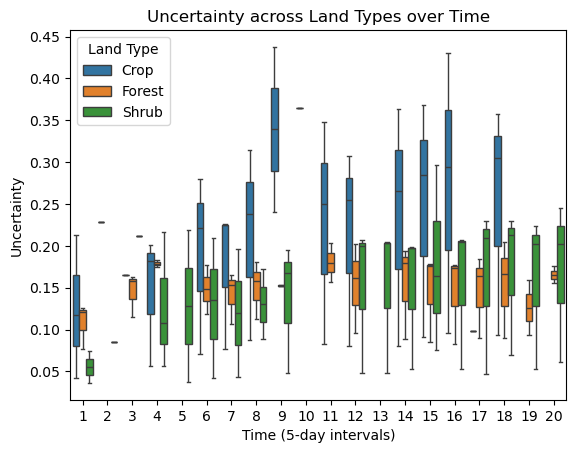

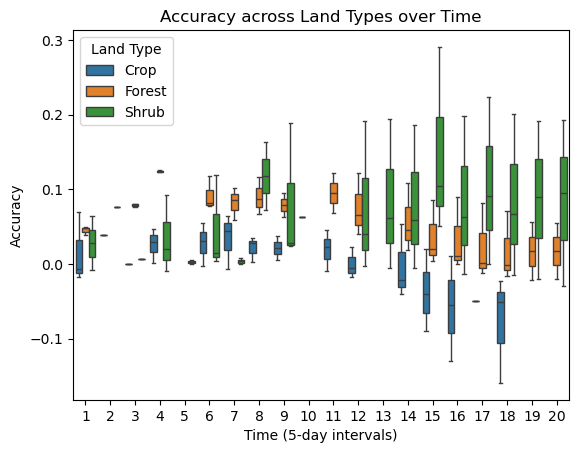

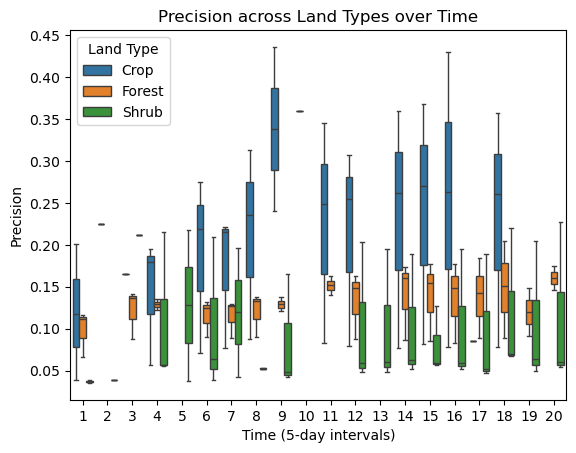

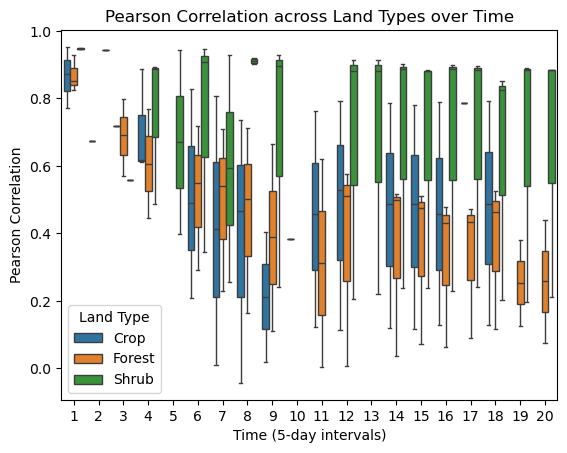

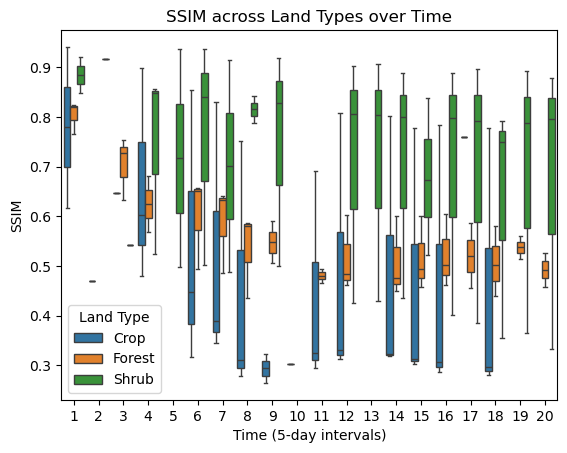

In [11]:
import xarray as xr
import numpy as np
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def ssim_wrapper(img1, img2):
    return ssim(img1, img2, data_range=2.0)

def calculate_metrics(input_nc, reference_nc, roi_lat=None, roi_lon=None, subsampling_factor=1):
    cloud_threshold = 0.2
    input_ndvi = xr.open_dataset(input_nc)["ndvi_pred"]
    reference = xr.open_dataset(reference_nc)
    reference_B4 = reference["s2_B04"]
    dates = reference.time.values
    
    for i in range(5): 
        if not reference_B4.sel(time=dates[i]).isnull().all().item():
            offset = i
            break
    
    for i in range(dates.size):
        if i < offset:
            reference = reference.drop_sel(time=dates[i])
        else:
            offset += 5
            if offset <55:
                reference = reference.drop_sel(time=dates[i])   

    reference["ndvi"] = (("time", "x", "y"), np.zeros((20, 128, 128)))
    reference["ndvi"] = (reference["s2_B8A"] - reference["s2_B04"]) / xr.where((reference["s2_B8A"] + reference["s2_B04"]) == 0, np.nan, (reference["s2_B8A"] + reference["s2_B04"]))
    
    masked = reference.where(reference["s2_dlmask"] == 0)
    reference_ndvi = masked["ndvi"]
    ssim_reference_ndvi = reference_ndvi.fillna(reference_ndvi.mean(dim=("lat", "lon"), skipna=True))
    residuals = input_ndvi - reference_ndvi

    U = np.sqrt((residuals**2).mean(dim=("lat", "lon"))) #RMSE
    A = (residuals).mean(dim=("lat", "lon"))
    P = np.sqrt(((residuals - A)**2).mean(dim=("lat", "lon")))
    R = xr.corr(input_ndvi, reference_ndvi, dim=("lat", "lon"))
    SSIM = xr.apply_ufunc(
        ssim_wrapper,
        input_ndvi,
        ssim_reference_ndvi,
        input_core_dims=[["lat","lon"], ["lat","lon"]],
        vectorize=True,
        output_dtypes=[float]
    )

    cloud = (reference["s2_dlmask"] == 0).sum(dim=["lat", "lon"]) < (128*128*(1-cloud_threshold))
    for i in range(20):
        if cloud[i].item():
            U[i] = np.nan
            A[i] = np.nan
            P[i] = np.nan
            R[i] = np.nan
            SSIM[i] = np.nan

    return {
        "Uncertainty": U,
        "Accuracy": A,
        "Precision": P,
        "Pearson Correlation": R,
        "SSIM": SSIM
    }

def gather_metrics(input_files, reference_files):
    U = []
    A = []
    P = []
    R = []
    SSIM = []
    for i in range(len(input_files)):
        metrics = calculate_metrics(input_files[i], reference_files[i])
        U.append(metrics["Uncertainty"])
        A.append(metrics["Accuracy"])
        P.append(metrics["Precision"])
        R.append(metrics["Pearson Correlation"])
        SSIM.append(metrics["SSIM"])
    return {
        "Uncertainty": U,
        "Accuracy": A,
        "Precision": P,
        "Pearson Correlation": R,
        "SSIM": SSIM
    }

def plot_metric(crop_datasets, forest_datasets, shrub_datasets, metric):
    datasets = [crop_datasets, forest_datasets, shrub_datasets]
    for l in range(3):
        for i in range(len(datasets[l])):
            datasets[l][i] = datasets[l][i].assign_coords(time=np.arange(1, datasets[l][i].sizes["time"] + 1)).to_dataframe(name=metric).reset_index().assign(land_type=["Crop", "Forest", "Shrub"][l])

    crop_data = pd.concat(datasets[0], ignore_index=True)
    forest_data = pd.concat(datasets[1], ignore_index=True)
    shrub_data = pd.concat(datasets[2], ignore_index=True)
    all_data = pd.concat([crop_data, forest_data, shrub_data], ignore_index=True)
    sns.boxplot(
        data=all_data,
        x="time",
        y=metric,
        hue="land_type"
    )

    # input = r"E:\DZ\predictions\contextformer6M_seed42\MJJ21\minicube_0_29SND_39.29_-8.56.nc"
# reference = r"E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_0_29SND_39.29_-8.56.nc"
input = r"E:\DZ\predictions\contextformer6M_seed42\MJJ21\minicube_225_34TET_47.37_22.05.nc"
reference = r"E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_225_34TET_47.37_22.05.nc"

crop_input = [
    r"E:\DZ\predictions\contextformer6M_seed42\MJJ21\minicube_0_29SND_39.29_-8.56.nc",
    r"E:\DZ\predictions\contextformer6M_seed42\MJJ21\minicube_1_29SND_39.34_-8.53.nc",
    r"E:\DZ\predictions\contextformer6M_seed42\MJJ21\minicube_2_29SND_38.90_-8.35.nc"

]

crop_reference = [
    r"E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_0_29SND_39.29_-8.56.nc",
    r"E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_1_29SND_39.34_-8.53.nc",
    r"E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_2_29SND_38.90_-8.35.nc"
]

forest_input = [
    r"E:\DZ\predictions\contextformer6M_seed42\MJJ21\minicube_3_29SPC_38.68_-7.65.nc",
    r"E:\DZ\predictions\contextformer6M_seed42\MJJ21\minicube_4_29SPC_38.66_-7.79.nc",
    r"E:\DZ\predictions\contextformer6M_seed42\MJJ21\minicube_5_29SPC_38.81_-6.73.nc"
]

forest_reference = [
    r"E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_3_29SPC_38.68_-7.65.nc",
    r"E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_4_29SPC_38.66_-7.79.nc",
    r"E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_5_29SPC_38.81_-6.73.nc"
]

shrub_input = [
    r"E:\DZ\predictions\contextformer6M_seed42\MJJ21\minicube_6_29SQB_37.12_-5.86.nc",
    r"E:\DZ\predictions\contextformer6M_seed42\MJJ21\minicube_7_29SQB_37.00_-6.50.nc",
    r"E:\DZ\predictions\contextformer6M_seed42\MJJ21\minicube_8_29SQB_37.77_-5.77.nc"
]   
shrub_reference = [
    r"E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_6_29SQB_37.12_-5.86.nc",
    r"E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_7_29SQB_37.00_-6.50.nc",
    r"E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_8_29SQB_37.77_-5.77.nc"
]

crop_datasets = gather_metrics(crop_input, crop_reference)
forest_datasets = gather_metrics(forest_input, forest_reference)
shrub_datasets = gather_metrics(shrub_input, shrub_reference)
metrics = ["Uncertainty", "Accuracy", "Precision", "Pearson Correlation", "SSIM"]
# print(crop_datasets["Uncertainty"])
for i in range(len(metrics)):
    # plt.figure(figsize=(10,6))
    plot_metric(crop_datasets[metrics[i]], forest_datasets[metrics[i]], shrub_datasets[metrics[i]], metrics[i])
    plt.title(f"{metrics[i]} across Land Types over Time")
    plt.xlabel("Time (5-day intervals)")
    plt.ylabel(metrics[i])
    plt.legend(title="Land Type")
    plt.show()

In [7]:

xr.open_dataset(r"E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_0_29SND_39.29_-8.56.nc")


<xarray.Dataset> Size: 119MB
Dimensions:              (time: 150, lon: 128, lat: 128)
Coordinates:
  * time                 (time) datetime64[ns] 1kB 2021-03-11 ... 2021-08-07
  * lon                  (lon) float64 1kB -8.571 -8.571 ... -8.542 -8.542
  * lat                  (lat) float64 1kB 39.3 39.3 39.3 ... 39.28 39.28 39.28
    sentinel:product_id  float64 8B ...
    latitude_eobs        float64 8B ...
    longitude_eobs       float64 8B ...
Data variables: (12/21)
    s2_SCL               (time, lat, lon) float64 20MB ...
    s2_avail             (time) float64 1kB ...
    s2_B02               (time, lat, lon) float64 20MB ...
    s2_B03               (time, lat, lon) float64 20MB ...
    s2_B04               (time, lat, lon) float64 20MB ...
    s2_B8A               (time, lat, lon) float64 20MB ...
    ...                   ...
    eobs_rr              (time) float64 1kB ...
    eobs_tg              (time) float64 1kB ...
    eobs_tn              (time) float64 1kB ...
    eobs_tx              (time) float64 1kB ...
    s2_dlmask            (time, lat, lon) float64 20MB ...
    eobs_fgv26           (time) float64 1kB ...
Attributes:
    dataset_name:        EarthNet2021x
    dataset_name_short:  en21x
    dataset_version:     v1.0
    description:         This is a minicube from the EarthNet2021x dataset, a...
    provided_by:         Max-Planck-Institute for Biogeochemistry